In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, f1_score, recall_score, precision_score, ConfusionMatrixDisplay

from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings('ignore')

In [ ]:
main = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')
df = main.copy()

In [ ]:
df_contacted = df.loc[df['prev_contacted']=="yes",:]
test_contacted = test.loc[test['prev_contacted']=="yes",:]

In [ ]:
df_contacted.shape,test_contacted.shape

((6691, 18), (1621, 18))

In [ ]:
#checking class unbalance
df_contacted['subscribed'].value_counts(),test_contacted['subscribed'].value_counts()

(subscribed
 no     5165
 yes    1526
 Name: count, dtype: int64,
 subscribed
 no     1233
 yes     388
 Name: count, dtype: int64)

In [ ]:
drop_columns = ['prev_contacted','day']

In [ ]:
df_contacted = df_contacted.drop(columns=drop_columns,axis=1)
test_contacted = test_contacted.drop(columns=drop_columns,axis=1)

In [ ]:
df_contacted['subscribed'] = np.where(df_contacted['subscribed']=='no',0,1)
test_contacted['subscribed'] = np.where(test_contacted['subscribed']=='no',0,1)

In [ ]:
df_contacted.info(), test_contacted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6691 entries, 4 to 36146
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         6691 non-null   float64
 1   job         6691 non-null   object 
 2   marital     6691 non-null   object 
 3   education   6691 non-null   object 
 4   default     6691 non-null   object 
 5   balance     6691 non-null   float64
 6   housing     6691 non-null   object 
 7   loan        6691 non-null   object 
 8   contact     6691 non-null   object 
 9   month       6691 non-null   object 
 10  duration    6691 non-null   int64  
 11  campaign    6691 non-null   int64  
 12  pdays       6691 non-null   int64  
 13  previous    6691 non-null   int64  
 14  poutcome    6691 non-null   object 
 15  subscribed  6691 non-null   int64  
dtypes: float64(2), int64(5), object(9)
memory usage: 888.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1621 entries, 2 to 9031
Data columns (total 16 col

(None, None)

In [ ]:
#checking Duplicates
df_contacted.duplicated().sum(), test_contacted.duplicated().sum()

(0, 0)

In [ ]:
#checking null
df_contacted.isnull().sum(), test_contacted.isnull().sum()

(age           0
 job           0
 marital       0
 education     0
 default       0
 balance       0
 housing       0
 loan          0
 contact       0
 month         0
 duration      0
 campaign      0
 pdays         0
 previous      0
 poutcome      0
 subscribed    0
 dtype: int64,
 age           0
 job           0
 marital       0
 education     0
 default       0
 balance       0
 housing       0
 loan          0
 contact       0
 month         0
 duration      0
 campaign      0
 pdays         0
 previous      0
 poutcome      0
 subscribed    0
 dtype: int64)

In [ ]:
#train test split
X_train=df_contacted.drop(columns=['subscribed'])
y_train=df_contacted['subscribed']
X_test=test_contacted.drop(columns=['subscribed'])
y_test=test_contacted['subscribed']

In [ ]:
#Preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

ords = ['education']
noms = ['job','marital','default','housing','loan','contact','month','poutcome']
quants = ['age','balance','duration','campaign','pdays','previous']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal',OrdinalEncoder(),ords),
        ('noms',OneHotEncoder(sparse_output=False),noms),
        ('quants',StandardScaler(),quants)
    ]
)

preprocessor_pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
    ]
)

# Without Resampling (Unbalanced case)

## Logistic Regression (Base Model)

In [ ]:
model_pipline = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',LogisticRegression())
    ]
)

model_pipline.fit(X_train,y_train)

y_preds = model_pipline.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1233
           1       0.73      0.53      0.62       388

    accuracy                           0.84      1621
   macro avg       0.80      0.74      0.76      1621
weighted avg       0.83      0.84      0.83      1621

AUC-ROC Score: 0.7981


In [ ]:
#training accuracy
y_preds_train = model_pipline.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5165
           1       0.70      0.53      0.60      1526

    accuracy                           0.84      6691
   macro avg       0.79      0.73      0.75      6691
weighted avg       0.83      0.84      0.83      6691



Text(0.5, 0, 'Predicted Label')

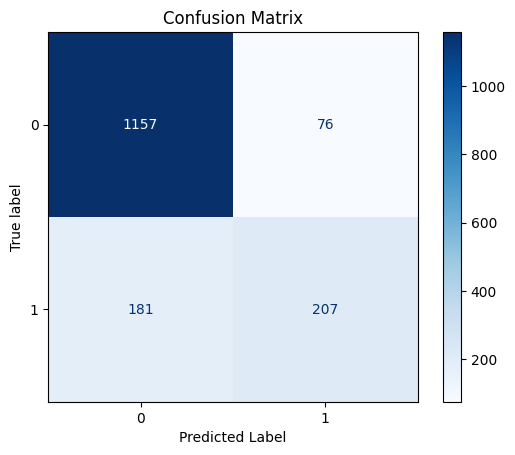

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### Assumption Check

In [ ]:
# Needed to run the logistic regression
import statsmodels.formula.api as smf

# For plotting/checking assumptions
import seaborn as sns

In [ ]:
X_train[noms] = X_train[noms].astype('category')
X_train[ords] = X_train[ords].astype('category')
X_test[noms]=X_test[noms].astype('category')
X_test[ords]=X_test[ords].astype('category')

In [ ]:
X_train1= pd.get_dummies(X_train)
X_test1= pd.get_dummies(X_test)

In [ ]:
df_train1=pd.concat([X_train,y_train],axis=1)
df_test1=pd.concat([X_test,y_test],axis=1)


In [ ]:
df_train1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'subscribed'],
      dtype='object')

In [ ]:
model= smf.logit(formula="subscribed~age+C(job)+C(marital)+C(education)+C(default)+balance+C(housing)+C(loan)+C(contact)+C(month)+duration+campaign+pdays+previous+C(poutcome)", data= df_train1).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.351324
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 6691
Model:                          Logit   Df Residuals:                     6649
Method:                           MLE   Df Model:                           41
Date:                Tue, 20 Aug 2024   Pseudo R-squ.:                  0.3457
Time:                        13:19:56   Log-Likelihood:                -2350.7
converged:                       True   LL-Null:                       -3592.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.9735      0.336     -8.841      0.000      -3.633      -2.314
C(job)[T.blue-collar]        -0.4267      0.154     -2.776      0.006      -0.728      -0.125
C(job)[T.entrepreneur]       -0.9158      0.322     -2.841      0.004      -1.548      -0.284
C(job)[T.housemaid]           0.0133      0.275      0.048      0.962      -0.526       0.552
C(job)[T.management]          0.0072      0.146      0.050      0.960      -0.279       0.294
C(job)[T.retired]            -0.0293      0.203     -0.144      0.885      -0.427       0.368
C(job)[T.self-employed]      -0.2193      0.227     -0.968      0.333      -0.664       0.225
C(job)[T.services]           -0.0895      0.173     -0.519      0.604      -0.428       0.249
C(job)[T.student]             0.1781      0.205      0.871      0.384      -0.223       0.579
C(job)[T.technician]         -0.1773      0.140     -1.271      0.204      -0.451       0.096
C(job)[T.unemployed]          0.3535      0.236      1.497      0.134      -0.109       0.816
C(job)[T.unknown]             0.0470      0.488      0.096      0.923      -0.910       1.004
C(marital)[T.married]         0.1225      0.126      0.972      0.331      -0.125       0.370
C(marital)[T.single]          0.1514      0.144      1.049      0.294      -0.132       0.434
C(education)[T.secondary]     0.1209      0.138      0.873      0.383      -0.151       0.392
C(education)[T.tertiary]      0.2792      0.159      1.760      0.078      -0.032       0.590
C(education)[T.unknown]       0.3790      0.215      1.761      0.078      -0.043       0.801
C(default)[T.yes]            -0.2422      0.574     -0.422      0.673      -1.368       0.883
C(housing)[T.yes]            -0.7095      0.088     -8.069      0.000      -0.882      -0.537
C(loan)[T.yes]               -0.3534      0.132     -2.685      0.007      -0.611      -0.095
C(contact)[T.telephone]      -0.3987      0.152     -2.623      0.009      -0.697      -0.101
C(contact)[T.unknown]        -0.3063      0.401     -0.763      0.445      -1.093       0.480
C(month)[T.aug]               0.9218      0.163      5.643      0.000       0.602       1.242
C(month)[T.dec]               0.4967      0.282      1.759      0.079      -0.057       1.050
C(month)[T.feb]               0.1864      0.157      1.190      0.234      -0.120       0.493
C(month)[T.jan]              -0.5388      0.211     -2.559      0.011      -0.951      -0.126
C(month)[T.jul]               1.1842      0.211      5.616      0.000       0.771       1.597
C(month)[T.jun]               0.9509      0.189      5.038      0.000       0.581       1.321
C(month)[T.mar]               1.2549      0.231      5.436      0.000       0.802       1.707
C(month)[T.may]              -0.2083      0.134     -1.556      0.120      -0.471       0.054
C(month)[T.nov]              -0.2307      0.157     -1.468      0.142      -0.539       0.077
C(month)[T.oct]               0.9824      0.1

In [ ]:
df_train2=pd.concat([X_train1,y_train],axis=1)
df_test2=pd.concat([X_test1,y_test],axis=1)

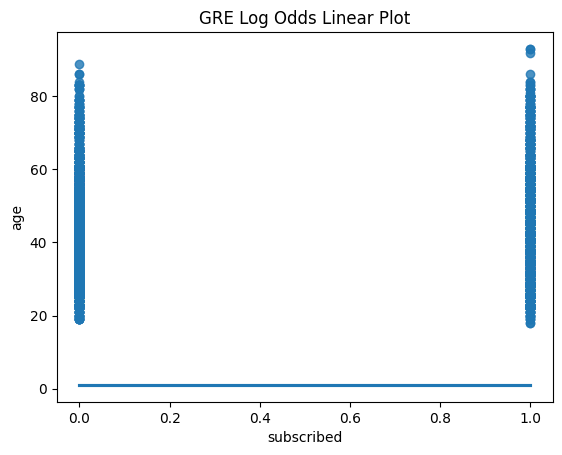

In [ ]:
gre = sns.regplot(x= 'subscribed', y= 'age', data= df_train2, logistic= True).set_title("GRE Log Odds Linear Plot")


In [ ]:
df_train2.corr()

age   balance  duration  campaign     pdays  \
age                  1.000000  0.115704  0.069315  0.006017 -0.102903   
balance              0.115704  1.000000  0.044152  0.002162 -0.099819   
duration             0.069315  0.044152  1.000000 -0.088340 -0.036626   
campaign             0.006017  0.002162 -0.088340  1.000000  0.047849   
pdays               -0.102903 -0.099819 -0.036626  0.047849  1.000000   
previous             0.003288  0.006784 -0.010469  0.182131 -0.030586   
job_admin.          -0.059045 -0.045123 -0.027738 -0.022129  0.022237   
job_blue-collar     -0.072184 -0.069576 -0.027555  0.038026  0.191983   
job_entrepreneur     0.015114 -0.017549  0.011526  0.029846 -0.003352   
job_housemaid        0.089130  0.013391 -0.013997  0.008900 -0.044199   
job_management      -0.025961  0.078038 -0.002455 -0.010783 -0.094114   
job_retired          0.557677  0.091504  0.078206 -0.034773 -0.110776   
job_self-employed   -0.016618  0.028400  0.015507 -0.012759 -0.037742   
job_services        -0.071531 -0.044392  0.000982  0.013442  0.075959   
job_student         -0.238073 -0.002057 -0.008294  0.011810 -0.062009   
job_technician      -0.062844 -0.004277 -0.013515 -0.003713 -0.032535   
job_unemployed      -0.006477 -0.008475  0.029396 -0.011233 -0.007333   
job_unknown          0.045535  0.000099  0.022538 -0.019710 -0.015813   
marital_divorced     0.162216 -0.000627  0.010448 -0.000730  0.028388   
marital_married      0.309490  0.029745  0.011838  0.004794 -0.003198   
marital_single      -0.441270 -0.031262 -0.019796 -0.004607 -0.016106   
education_primary    0.208167 -0.013567  0.026884  0.011122  0.058715   
education_secondary -0.089140 -0.086392 -0.030667  0.011864  0.107716   
education_tertiary  -0.084410  0.097746  0.009617 -0.020749 -0.150065   
education_unknown    0.078573  0.010843  0.010192  0.000365 -0.016943   
default_no           0.026279  0.046083  0.000706  0.001139 -0.026566   
default_yes         -0.026279 -0.046083 -0.000706 -0.001139  0.026566   
housing_no           0.184497  0.105382  0.077441 -0.062091 -0.324392   
housing_yes         -0.184497 -0.105382 -0.077441  0.062091  0.324392   
loan_no              0.013334  0.088005  0.036771 -0.004048 -0.022263   
loan_yes            -0.013334 -0.088005 -0.036771  0.004048  0.022263   
contact_cellular    -0.191422 -0.027218  0.027125 -0.098201 -0.032673   
contact_telephone    0.201132  0.032004 -0.007421  0.122003 -0.021829   
contact_unknown      0.000574 -0.009512 -0.059460 -0.052722  0.158291   
month_apr           -0.045397 -0.005957  0.058198 -0.037943  0.083576   
month_aug            0.013279  0.016250  0.000971 -0.037754 -0.106585   
month_dec            0.024959  0.055559  0.047440  0.029694 -0.028789   
month_feb            0.027624 -0.030404 -0.023739  0.042039 -0.078069   
month_jan            0.039475 -0.044917 -0.031630 -0.050187 -0.073148   
month_jul            0.035699  0.017311  0.037818  0.000955  0.017714   
month_jun           -0.000979  0.027610  0.015124 -0.034023 -0.098339   
month_mar            0.030280  0.026432 -0.003878 -0.009090 -0.026225   
month_may           -0.113489 -0.085718 -0.039345  0.114119  0.374037   
month_nov            0.034635  0.077477 -0.036933 -0.028444 -0.263434   
month_oct            0.067535  0.036691  0.024853 -0.056037 -0.076911   
month_sep            0.041474  0.025659  0.033988 -0.032731 -0.015675   
poutcome_failure    -0.022914 -0.040291 -0.077149 -0.054035  0.172676   
poutcome_other      -0.052997 -0.006661 -0.015336  0.137700  0.023292   
poutcome_success     0.087040  0.058979  0.114303 -0.080607 -0.245661   
poutcome_unknown    -0.004297 -0.004785  0.013360  0.002906 -0.001617   
subscribed           0.084903  0.074594  0.340103 -0.090377 -0.155889   

                     previous  job_admin.  job_blue-collar  job_entrepreneur  \
age                  0.003288   -0.059045        -0.072184          0.015114   
balance              0.006784   -0.045123        -0.069576         -0

## Banging Techniques and Ensembled Techniques


### Starndard Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
model_pipline2 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',BaggingClassifier(random_state=123))
    ]
)

model_pipline2.fit(X_train,y_train)

y_preds = model_pipline2.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1233
           1       0.93      0.89      0.91       388

    accuracy                           0.96      1621
   macro avg       0.95      0.93      0.94      1621
weighted avg       0.96      0.96      0.96      1621

AUC-ROC Score: 0.9478


In [ ]:
#training accuracy
y_preds_train = model_pipline2.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5165
           1       1.00      0.95      0.97      1526

    accuracy                           0.99      6691
   macro avg       0.99      0.98      0.98      6691
weighted avg       0.99      0.99      0.99      6691



Text(0.5, 0, 'Predicted Label')

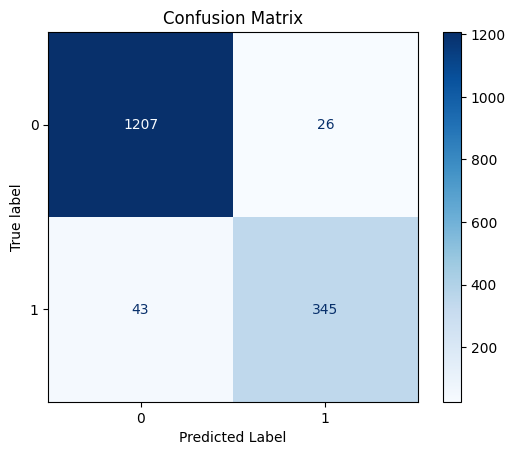

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyperparamete tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_samples': [0.5, 0.7, 1.0],
    'model__max_features': [0.5, 0.7, 1.0],
}

grid_search2 = GridSearchCV(model_pipline2,
                           param_grid=param_grid)
sb_tuned1=grid_search2.fit(X_train,y_train)
print(grid_search2.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous'])])),
                ('model',
                 BaggingClassifier(max_features=0.7, max_samples=0.5,
                                   n_estimators=

In [ ]:
y_preds_sb_tn = sb_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_sb_tn))
auc_score_sb_tn = roc_auc_score(y_preds_sb_tn,y_test)
print(f"AUC-ROC Score: {auc_score_sb_tn:.4f}")

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1233
           1       0.94      0.84      0.89       388

    accuracy                           0.95      1621
   macro avg       0.95      0.91      0.93      1621
weighted avg       0.95      0.95      0.95      1621

AUC-ROC Score: 0.9473


In [ ]:
#training accuracy
y_preds_train_sb_tn = sb_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sb_tn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5165
           1       0.98      0.90      0.94      1526

    accuracy                           0.97      6691
   macro avg       0.98      0.95      0.96      6691
weighted avg       0.97      0.97      0.97      6691



Text(0.5, 0, 'Predicted Label')

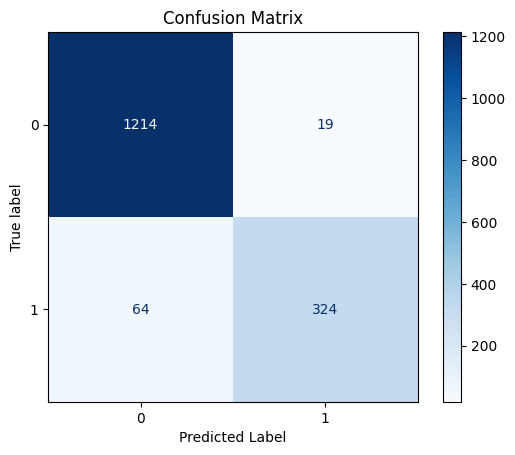

In [ ]:
cm_sb_tn = confusion_matrix(y_test, y_preds_sb_tn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sb_tn)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
model_pipline1 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',RandomForestClassifier(random_state=123))
    ]
)

model_pipline1.fit(X_train,y_train)

y_preds = model_pipline1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1233
           1       0.94      0.91      0.93       388

    accuracy                           0.96      1621
   macro avg       0.96      0.95      0.95      1621
weighted avg       0.96      0.96      0.96      1621

AUC-ROC Score: 0.9558


In [ ]:
#training accuracy
y_preds_train = model_pipline1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5165
           1       1.00      1.00      1.00      1526

    accuracy                           1.00      6691
   macro avg       1.00      1.00      1.00      6691
weighted avg       1.00      1.00      1.00      6691



Text(0.5, 0, 'Predicted Label')

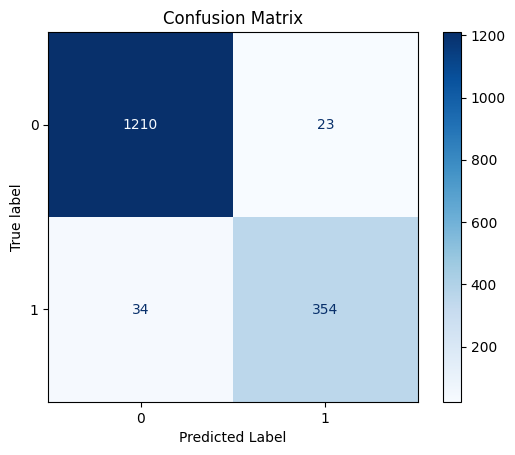

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_estimators': [50,100,200],
    'model__max_depth': [None,20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 3]
}

grid_search1 = GridSearchCV(model_pipline1,
                           param_grid=param_grid)
rf_tuned1=grid_search1.fit(X_train,y_train)
print(grid_search1.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous'])])),
                ('model',
                 RandomForestClassifier(min_samples_split=10, n_estimators=200,
                                      

In [ ]:
y_preds_rf_tn = rf_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_rf_tn))
auc_score_rf_tn = roc_auc_score(y_preds_rf_tn,y_test)
print(f"AUC-ROC Score: {auc_score_rf_tn:.4f}")

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1233
           1       0.90      0.80      0.85       388

    accuracy                           0.93      1621
   macro avg       0.92      0.88      0.90      1621
weighted avg       0.93      0.93      0.93      1621

AUC-ROC Score: 0.9195


In [ ]:
#training accuracy
y_preds_train_rf_tn = rf_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_rf_tn))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5165
           1       0.94      0.83      0.88      1526

    accuracy                           0.95      6691
   macro avg       0.95      0.91      0.93      6691
weighted avg       0.95      0.95      0.95      6691



Text(0.5, 0, 'Predicted Label')

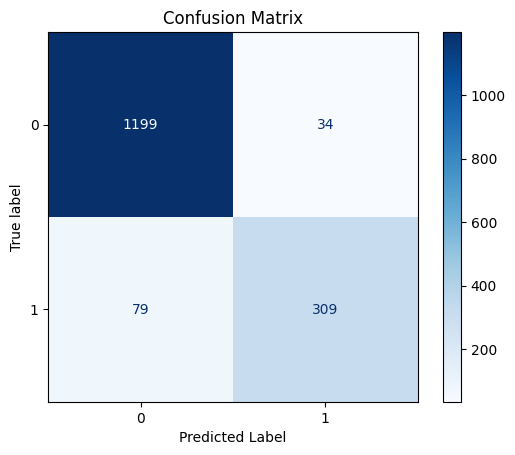

In [ ]:
cm_rf_tn = confusion_matrix(y_test, y_preds_rf_tn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tn)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## Boosting Techniques

### Ada Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model_pipline = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',AdaBoostClassifier(random_state=123))
    ]
)

model_pipline.fit(X_train,y_train)

y_preds = model_pipline.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1233
           1       0.77      0.58      0.66       388

    accuracy                           0.86      1621
   macro avg       0.82      0.76      0.79      1621
weighted avg       0.85      0.86      0.85      1621

AUC-ROC Score: 0.8246


In [ ]:
#training accuracy
y_preds_train = model_pipline.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))


              precision    recall  f1-score   support

           0       0.88      0.94      0.91      5165
           1       0.73      0.57      0.64      1526

    accuracy                           0.85      6691
   macro avg       0.80      0.75      0.77      6691
weighted avg       0.85      0.85      0.85      6691



Text(0.5, 0, 'Predicted Label')

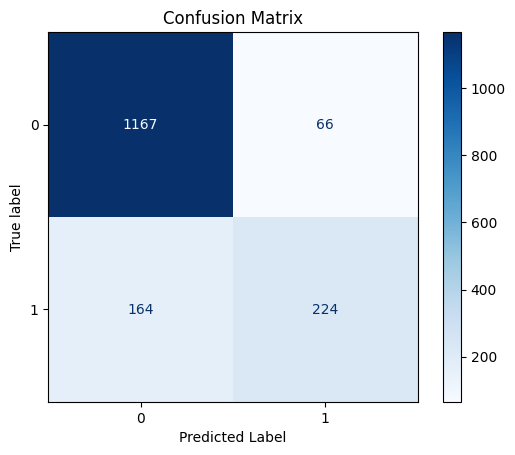

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### XGB

In [ ]:
from xgboost import XGBClassifier
model_pipline = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',XGBClassifier(random_state=123))
    ]
)

model_pipline.fit(X_train,y_train)

y_preds = model_pipline.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1233
           1       0.91      0.89      0.90       388

    accuracy                           0.95      1621
   macro avg       0.94      0.93      0.93      1621
weighted avg       0.95      0.95      0.95      1621

AUC-ROC Score: 0.9359


In [ ]:
#training accuracy
y_preds_train = model_pipline.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5165
           1       0.97      0.95      0.96      1526

    accuracy                           0.98      6691
   macro avg       0.98      0.97      0.97      6691
weighted avg       0.98      0.98      0.98      6691



Text(0.5, 0, 'Predicted Label')

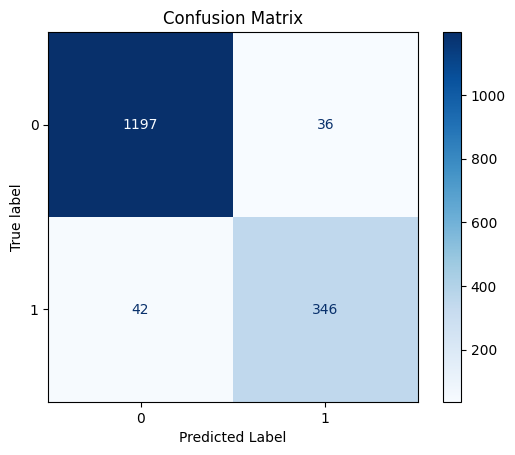

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## SVM

In [ ]:
from sklearn.svm import SVC
model_pipline4 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',SVC(random_state=123))
    ]
)

model_pipline4.fit(X_train,y_train)

y_preds = model_pipline4.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1233
           1       0.81      0.63      0.71       388

    accuracy                           0.88      1621
   macro avg       0.85      0.79      0.81      1621
weighted avg       0.87      0.88      0.87      1621

AUC-ROC Score: 0.8515


In [ ]:
#training accuracy
y_preds_train = model_pipline4.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      5165
           1       0.77      0.62      0.69      1526

    accuracy                           0.87      6691
   macro avg       0.83      0.78      0.80      6691
weighted avg       0.87      0.87      0.87      6691



Text(0.5, 0, 'Predicted Label')

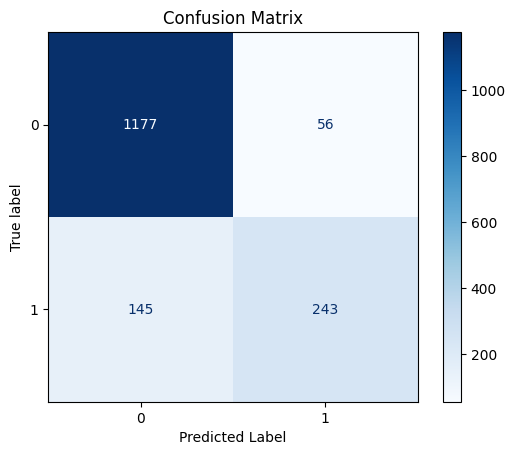

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyperparameter tune

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__degree': [2, 3, 4]
}

grid_search2 = GridSearchCV(model_pipline4,
                           param_grid=param_grid)
svm_tuned1=grid_search2.fit(X_train,y_train)
print(grid_search2.best_estimator_)

In [ ]:
y_preds_svm_tn = svm_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_svm_tn))
auc_score_svm_tn = roc_auc_score(y_preds_svm_tn,y_test)
print(f"AUC-ROC Score: {auc_score_svm_tn:.4f}")

In [ ]:
#training accuracy
y_preds_train_svm_tn = svm_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_svm_tn))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_pipline5 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',KNeighborsClassifier(n_neighbors=2))
    ]
)

model_pipline5.fit(X_train,y_train)

y_preds = model_pipline5.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1233
           1       0.90      0.49      0.63       388

    accuracy                           0.86      1621
   macro avg       0.88      0.73      0.77      1621
weighted avg       0.87      0.86      0.85      1621

AUC-ROC Score: 0.8773


In [ ]:
#training accuracy
y_preds_train = model_pipline5.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      5165
           1       1.00      0.52      0.69      1526

    accuracy                           0.89      6691
   macro avg       0.94      0.76      0.81      6691
weighted avg       0.90      0.89      0.88      6691



Text(0.5, 0, 'Predicted Label')

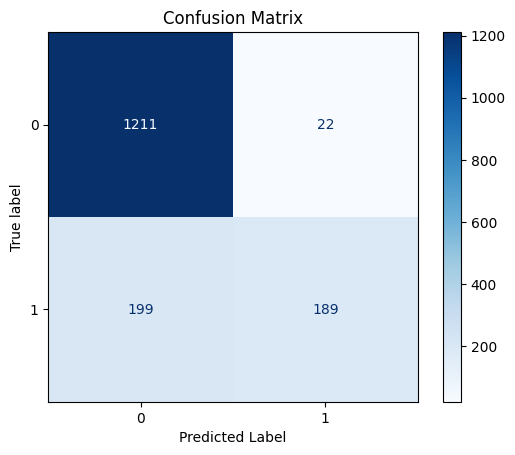

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyper parameters tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_neighbors': [2,3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

grid_search4 = GridSearchCV(model_pipline5,
                           param_grid=param_grid)
knn_tuned1=grid_search4.fit(X_train,y_train)
print(grid_search4.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous'])])),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=9))])


In [ ]:
y_preds_knn_tn = knn_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_knn_tn))
auc_score_knn_tn = roc_auc_score(y_preds_knn_tn,y_test)
print(f"AUC-ROC Score: {auc_score_knn_tn:.4f}")

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1233
           1       0.79      0.53      0.63       388

    accuracy                           0.85      1621
   macro avg       0.83      0.74      0.77      1621
weighted avg       0.85      0.85      0.84      1621

AUC-ROC Score: 0.8302


In [ ]:
#training accuracy
y_preds_train_knn_tn = knn_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_knn_tn))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5165
           1       0.77      0.56      0.65      1526

    accuracy                           0.86      6691
   macro avg       0.83      0.76      0.78      6691
weighted avg       0.86      0.86      0.85      6691



## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model_pipline6 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',BernoulliNB())
    ]
)

model_pipline6.fit(X_train,y_train)

y_preds = model_pipline6.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      1233
           1       0.57      0.71      0.63       388

    accuracy                           0.80      1621
   macro avg       0.74      0.77      0.75      1621
weighted avg       0.82      0.80      0.81      1621

AUC-ROC Score: 0.7357


In [ ]:
#training accuracy
y_preds_train = model_pipline6.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5165
           1       0.56      0.68      0.62      1526

    accuracy                           0.81      6691
   macro avg       0.73      0.76      0.74      6691
weighted avg       0.82      0.81      0.81      6691



Text(0.5, 0, 'Predicted Label')

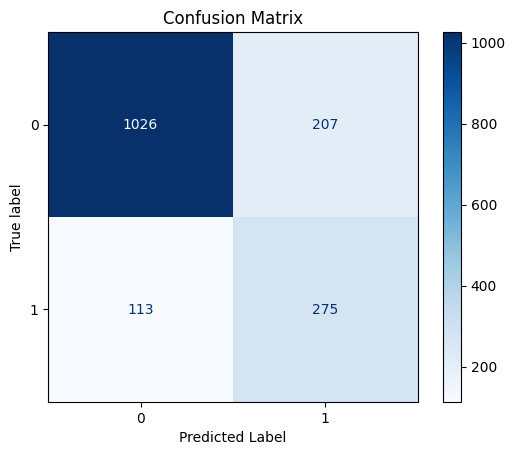

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__alpha': [0.1, 0.5, 1.0],
    'model__binarize': [0.0, 0.1, 0.5],
    'model__fit_prior': [True, False]
}

grid_search7 = GridSearchCV(model_pipline6,
                           param_grid=param_grid)
nb_tuned1=grid_search7.fit(X_train,y_train)
print(grid_search7.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous'])])),
                ('model', BernoulliNB(alpha=0.1))])


In [ ]:
y_preds_nb_tn = nb_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_nb_tn))
auc_score_nb_tn = roc_auc_score(y_preds_nb_tn,y_test)
print(f"AUC-ROC Score: {auc_score_nb_tn:.4f}")

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1233
           1       0.57      0.71      0.63       388

    accuracy                           0.80      1621
   macro avg       0.74      0.77      0.75      1621
weighted avg       0.82      0.80      0.81      1621

AUC-ROC Score: 0.7350


In [ ]:
#training accuracy
y_preds_train = nb_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5165
           1       0.56      0.68      0.62      1526

    accuracy                           0.81      6691
   macro avg       0.73      0.76      0.74      6691
weighted avg       0.82      0.81      0.81      6691



From initial analysis without smote Random Forest and XGB works best with data set

## Catboost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=2000,          # Number of boosting iterations
    learning_rate=0.1,        # Learning rate
    depth=6,                  # Depth of the trees
    loss_function='Logloss',  # Loss function for binary classification
    eval_metric='AUC',        # Evaluation metric
    verbose=100,              # Print training progress every 100 iterations
    random_seed=123           # Ensures reproducibility
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=['job','marital','default','housing','loan','contact','month','poutcome','education'])

# Make predictions on the test set
y_pred = model.predict(X_test)

0:	test: 0.8761831	best: 0.8761831 (0)	total: 148ms	remaining: 4m 56s
100:	test: 0.9246160	best: 0.9246160 (100)	total: 4.91s	remaining: 1m 32s
200:	test: 0.9384453	best: 0.9384453 (200)	total: 6.85s	remaining: 1m 1s
300:	test: 0.9455523	best: 0.9456401 (298)	total: 8.34s	remaining: 47.1s
400:	test: 0.9520949	best: 0.9520970 (399)	total: 9.89s	remaining: 39.4s
500:	test: 0.9565597	best: 0.9565785 (499)	total: 11.5s	remaining: 34.3s
600:	test: 0.9599669	best: 0.9599669 (600)	total: 13s	remaining: 30.4s
700:	test: 0.9623498	best: 0.9624021 (699)	total: 15.6s	remaining: 28.9s
800:	test: 0.9653640	best: 0.9653661 (798)	total: 19.7s	remaining: 29.5s
900:	test: 0.9670258	best: 0.9670320 (898)	total: 21.3s	remaining: 25.9s
1000:	test: 0.9692958	best: 0.9692958 (1000)	total: 22.8s	remaining: 22.8s
1100:	test: 0.9705960	best: 0.9705960 (1100)	total: 24.4s	remaining: 19.9s
1200:	test: 0.9714676	best: 0.9714676 (1200)	total: 25.9s	remaining: 17.2s
1300:	test: 0.9726215	best: 0.9726215 (1300)	tota

In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))
auc_score = roc_auc_score(y_pred,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1233
           1       0.89      0.86      0.87       388

    accuracy                           0.94      1621
   macro avg       0.92      0.91      0.92      1621
weighted avg       0.94      0.94      0.94      1621

AUC-ROC Score: 0.9238


In [ ]:
#training accuracy
y_preds_train_cat1 = model.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_cat1))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5165
           1       0.95      0.92      0.94      1526

    accuracy                           0.97      6691
   macro avg       0.97      0.95      0.96      6691
weighted avg       0.97      0.97      0.97      6691



Text(0.5, 0, 'Predicted Label')

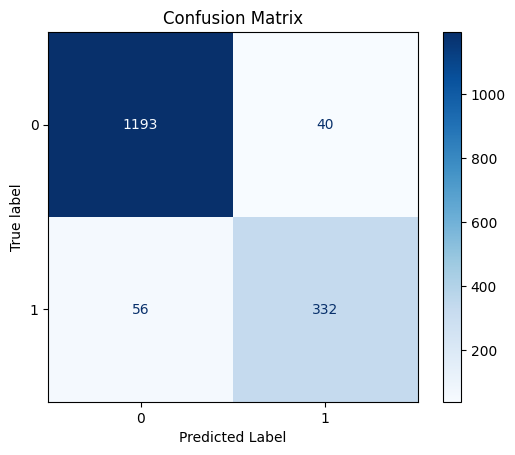

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10],
    'n_estimators': [100, 200, 300],
}

model111 = CatBoostClassifier(learning_rate=0.1, depth=6, n_estimators=100, l2_leaf_reg=1, subsample=0.8, cat_features=['job','marital','default','housing','loan','contact','month','poutcome','education'])
grid_search111 = GridSearchCV(model111, param_grid, cv=3, scoring='accuracy')
nb_tuned1=grid_search111.fit(X_train,y_train)
print(grid_search111.best_estimator_)


Streaming output truncated to the last 5000 lines.
1:	learn: 0.6741359	total: 72.5ms	remaining: 7.18s
2:	learn: 0.6660258	total: 84.2ms	remaining: 5.53s
3:	learn: 0.6577387	total: 96ms	remaining: 4.7s
4:	learn: 0.6494791	total: 107ms	remaining: 4.17s
5:	learn: 0.6430068	total: 113ms	remaining: 3.64s
6:	learn: 0.6333312	total: 148ms	remaining: 4.09s
7:	learn: 0.6276046	total: 154ms	remaining: 3.69s
8:	learn: 0.6175986	total: 190ms	remaining: 4.03s
9:	learn: 0.6087384	total: 225ms	remaining: 4.27s
10:	learn: 0.5997285	total: 270ms	remaining: 4.64s
11:	learn: 0.5913375	total: 306ms	remaining: 4.79s
12:	learn: 0.5837608	total: 342ms	remaining: 4.92s
13:	learn: 0.5766655	total: 382ms	remaining: 5.07s
14:	learn: 0.5689368	total: 420ms	remaining: 5.18s
15:	learn: 0.5603276	total: 456ms	remaining: 5.24s
16:	learn: 0.5541521	total: 469ms	remaining: 5.05s
17:	learn: 0.5474817	total: 516ms	remaining: 5.22s
18:	learn: 0.5414651	total: 525ms	remaining: 5s
19:	learn: 0.5355940	total: 536ms	remaining

In [ ]:
y_preds_cat_tn = nb_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_cat_tn))
auc_score_cat_tn = roc_auc_score(y_preds_cat_tn,y_test)
print(f"AUC-ROC Score: {auc_score_cat_tn:.4f}")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1233
           1       0.89      0.85      0.87       388

    accuracy                           0.94      1621
   macro avg       0.92      0.91      0.92      1621
weighted avg       0.94      0.94      0.94      1621

AUC-ROC Score: 0.9235


In [ ]:
#training accuracy
y_preds_train_cat = nb_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_cat))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5165
           1       0.94      0.88      0.90      1526

    accuracy                           0.96      6691
   macro avg       0.95      0.93      0.94      6691
weighted avg       0.96      0.96      0.96      6691



# With Smote

In [ ]:

x_train_preprocessed = preprocessor.fit_transform(X_train)
x_test_preproecessed = preprocessor.fit_transform(X_test)
smt = SMOTE(sampling_strategy=1, random_state=123)
X_train_sm, y_train_sm = smt.fit_resample(x_train_preprocessed, y_train)

In [ ]:
y_train_sm.value_counts()

subscribed
0    5165
1    5165
Name: count, dtype: int64

## Logistic Regression as Base Model

In [ ]:
model1=LogisticRegression()

model1.fit(X_train_sm,y_train_sm)
y_preds_sm1 = model1.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm1))
auc_score1 = roc_auc_score(y_preds_sm1,y_test)
print(f"AUC-ROC Score: {auc_score1:.4f}")

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1233
           1       0.55      0.87      0.67       388

    accuracy                           0.80      1621
   macro avg       0.75      0.82      0.76      1621
weighted avg       0.85      0.80      0.81      1621

AUC-ROC Score: 0.7502


In [ ]:
#training accuracy
y_preds_train_sm1 = model1.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm1))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      5165
           1       0.54      0.84      0.66      1526

    accuracy                           0.80      6691
   macro avg       0.74      0.81      0.76      6691
weighted avg       0.85      0.80      0.81      6691



Text(0.5, 0, 'Predicted Label')

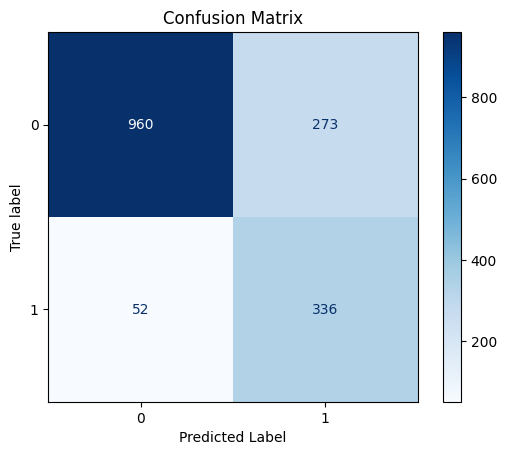

In [ ]:
cm1 = confusion_matrix(y_test, y_preds_sm1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## Bagging and Ensembeled methods

## Standard Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
model21=BaggingClassifier(random_state=123)

model21.fit(X_train_sm,y_train_sm)
y_preds_sm21 = model21.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm21))
auc_score21 = roc_auc_score(y_preds_sm21,y_test)
print(f"AUC-ROC Score: {auc_score21:.4f}")

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1233
           1       0.81      0.89      0.85       388

    accuracy                           0.92      1621
   macro avg       0.89      0.91      0.90      1621
weighted avg       0.93      0.92      0.92      1621

AUC-ROC Score: 0.8873


In [ ]:
  #training accuracy
y_preds_train_sm21 = model21.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm21))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5165
           1       0.99      0.98      0.98      1526

    accuracy                           0.99      6691
   macro avg       0.99      0.99      0.99      6691
weighted avg       0.99      0.99      0.99      6691



Text(0.5, 0, 'Predicted Label')

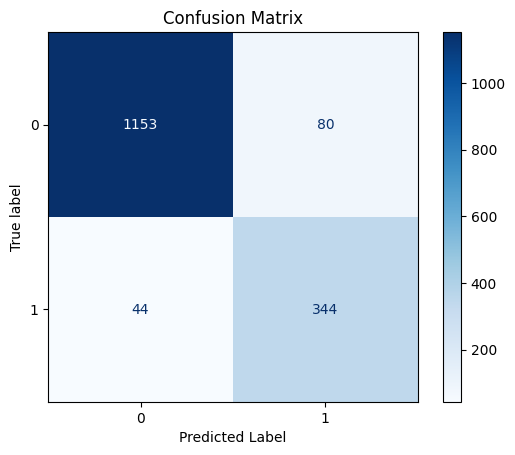

In [ ]:
cm21 = confusion_matrix(y_test, y_preds_sm21)
disp = ConfusionMatrixDisplay(confusion_matrix=cm21)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

grid_search6 = GridSearchCV(BaggingClassifier(random_state=123),
                           param_grid=param_grid)
sb_tuned=grid_search6.fit(X_train_sm,y_train_sm)
print(grid_search6.best_estimator_)

BaggingClassifier(max_features=0.7, n_estimators=200, random_state=123)


In [ ]:
y_preds_sm2_sb = grid_search6.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2_sb))
auc_score2_sb = roc_auc_score(y_preds_sm2_sb,y_test)
print(f"AUC-ROC Score: {auc_score2_sb:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1233
           1       0.83      0.93      0.88       388

    accuracy                           0.94      1621
   macro avg       0.90      0.93      0.92      1621
weighted avg       0.94      0.94      0.94      1621

AUC-ROC Score: 0.9039


In [ ]:
#training accuracy
y_preds_train_sm2_sb = sb_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2_sb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5165
           1       1.00      1.00      1.00      1526

    accuracy                           1.00      6691
   macro avg       1.00      1.00      1.00      6691
weighted avg       1.00      1.00      1.00      6691



Text(0.5, 0, 'Predicted Label')

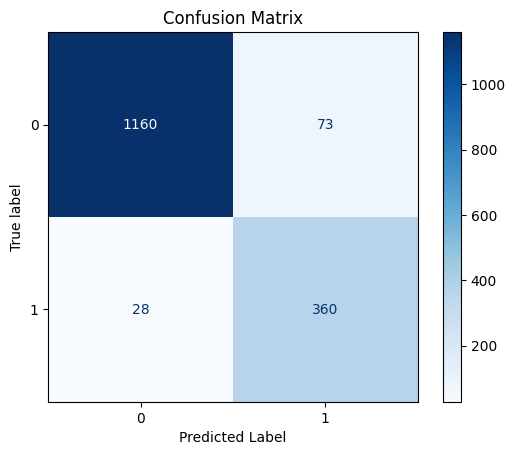

In [ ]:
cm2_sb = confusion_matrix(y_test, y_preds_sm2_sb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2_sb)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### Random Forest

In [ ]:
model2=RandomForestClassifier(random_state=123)

model2.fit(X_train_sm,y_train_sm)
y_preds_sm2 = model2.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2))
auc_score2 = roc_auc_score(y_preds_sm2,y_test)
print(f"AUC-ROC Score: {auc_score2:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1233
           1       0.89      0.92      0.91       388

    accuracy                           0.95      1621
   macro avg       0.93      0.94      0.94      1621
weighted avg       0.96      0.95      0.95      1621

AUC-ROC Score: 0.9330


In [ ]:
#training accuracy
y_preds_train_sm2 = model2.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5165
           1       1.00      1.00      1.00      1526

    accuracy                           1.00      6691
   macro avg       1.00      1.00      1.00      6691
weighted avg       1.00      1.00      1.00      6691



Text(0.5, 0, 'Predicted Label')

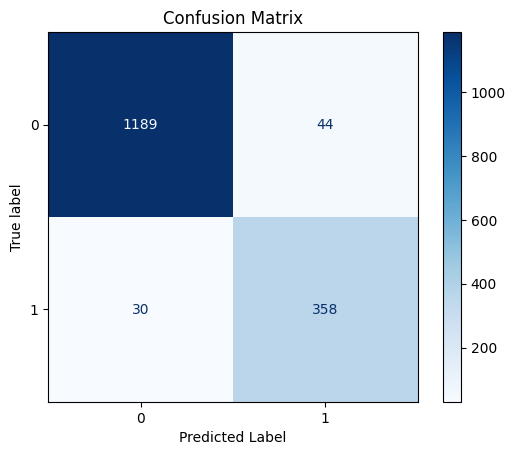

In [ ]:
cm2 = confusion_matrix(y_test, y_preds_sm2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyperparameter tune

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None,20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

grid_search9 = GridSearchCV(RandomForestClassifier(random_state=123),
                           param_grid=param_grid)
rf_tuned=grid_search9.fit(X_train_sm,y_train_sm)
print(grid_search9.best_estimator_)

RandomForestClassifier(n_estimators=200, random_state=123)


In [ ]:
y_preds_sm2_rf = grid_search9.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2_rf))
auc_score2_rf = roc_auc_score(y_preds_sm2_rf,y_test)
print(f"AUC-ROC Score: {auc_score2_rf:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1233
           1       0.89      0.92      0.90       388

    accuracy                           0.95      1621
   macro avg       0.93      0.94      0.94      1621
weighted avg       0.95      0.95      0.95      1621

AUC-ROC Score: 0.9324


In [ ]:
#training accuracy
y_preds_train_sm2_rf = rf_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5165
           1       1.00      1.00      1.00      1526

    accuracy                           1.00      6691
   macro avg       1.00      1.00      1.00      6691
weighted avg       1.00      1.00      1.00      6691



## Boosting Methods

### XGB

In [ ]:
from xgboost import XGBClassifier
model3=XGBClassifier(random_state=123)

model3.fit(X_train_sm,y_train_sm)
y_preds_sm3 = model3.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm3))
auc_score3 = roc_auc_score(y_preds_sm3,y_test)
print(f"AUC-ROC Score: {auc_score3:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.76      0.86      1233
           1       0.55      0.94      0.70       388

    accuracy                           0.80      1621
   macro avg       0.76      0.85      0.78      1621
weighted avg       0.87      0.80      0.82      1621

AUC-ROC Score: 0.7637


In [ ]:
#training accuracy
y_preds_train_sm3 = model3.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm3))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5165
           1       0.95      0.94      0.95      1526

    accuracy                           0.98      6691
   macro avg       0.97      0.96      0.97      6691
weighted avg       0.98      0.98      0.98      6691



Text(0.5, 0, 'Predicted Label')

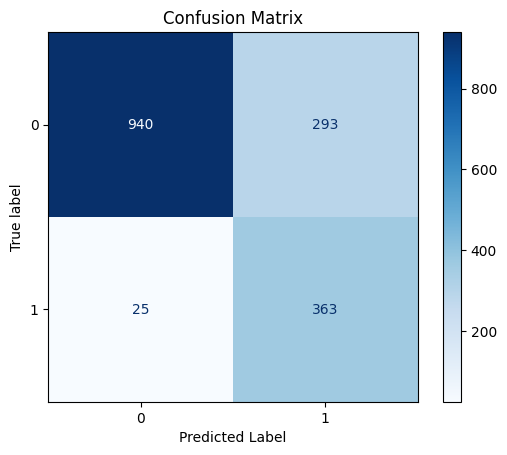

In [ ]:
cm3 = confusion_matrix(y_test, y_preds_sm3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### Ada Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model5=AdaBoostClassifier(random_state=123)

model5.fit(X_train_sm,y_train_sm)
y_preds_sm5 = model5.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm5))
auc_score5 = roc_auc_score(y_preds_sm5,y_test)
print(f"AUC-ROC Score: {auc_score5:.4f}")

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1233
           1       0.47      0.87      0.61       388

    accuracy                           0.74      1621
   macro avg       0.71      0.78      0.71      1621
weighted avg       0.83      0.74      0.76      1621

AUC-ROC Score: 0.7077


In [ ]:
#training accuracy
y_preds_train_sm5 = model5.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm5))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5165
           1       0.63      0.72      0.67      1526

    accuracy                           0.84      6691
   macro avg       0.77      0.80      0.78      6691
weighted avg       0.85      0.84      0.84      6691



Text(0.5, 0, 'Predicted Label')

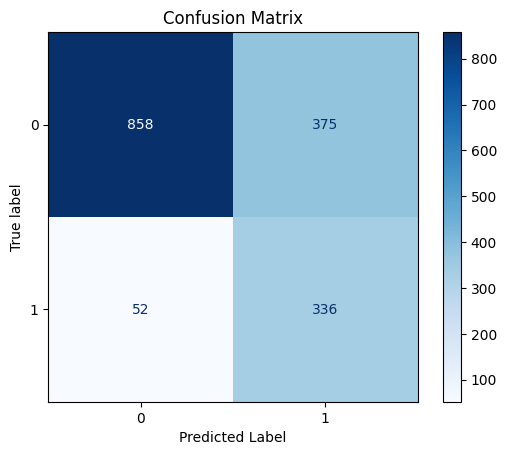

In [ ]:
cm5 = confusion_matrix(y_test, y_preds_sm5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## SVM

In [ ]:
from sklearn.svm import SVC
model6=SVC(random_state=123)

model6.fit(X_train_sm,y_train_sm)
y_preds_sm6 = model6.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm6))
auc_score6 = roc_auc_score(y_preds_sm6,y_test)
print(f"AUC-ROC Score: {auc_score6:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1233
           1       0.63      0.92      0.74       388

    accuracy                           0.85      1621
   macro avg       0.80      0.87      0.82      1621
weighted avg       0.89      0.85      0.86      1621

AUC-ROC Score: 0.7978


In [ ]:
#training accuracy
y_preds_train_sm6 = model6.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm6))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      5165
           1       0.61      0.94      0.74      1526

    accuracy                           0.85      6691
   macro avg       0.80      0.88      0.82      6691
weighted avg       0.89      0.85      0.86      6691



Text(0.5, 0, 'Predicted Label')

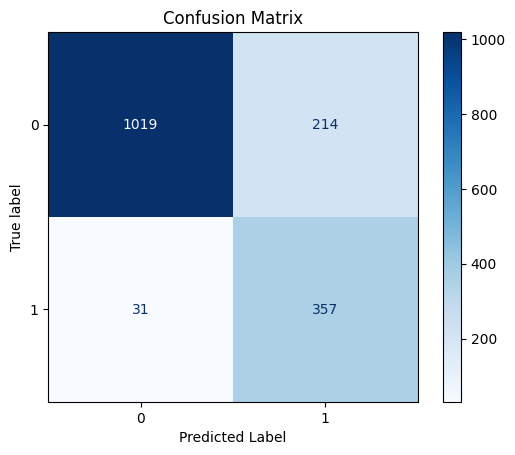

In [ ]:
cm6 = confusion_matrix(y_test, y_preds_sm6)
disp = ConfusionMatrixDisplay(confusion_matrix=cm6)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tuned

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]
}

grid_search10 = GridSearchCV(SVC(random_state=123),
                           param_grid=param_grid)
svm_tuned=grid_search10.fit(X_train_sm,y_train_sm)
print(grid_search10.best_estimator_)

In [ ]:
y_preds_sm2_svm = grid_search10.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2_svm))
auc_score2_svm = roc_auc_score(y_preds_sm2_svm,y_test)
print(f"AUC-ROC Score: {auc_score2_svm:.4f}")

In [ ]:
#training accuracy
y_preds_train_sm2_svm = grid_search10.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2_svm))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model7=KNeighborsClassifier(n_neighbors=2)

model7.fit(X_train_sm,y_train_sm)
y_preds_sm7 = model7.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm7))
auc_score7 = roc_auc_score(y_preds_sm7,y_test)
print(f"AUC-ROC Score: {auc_score7:.4f}")

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1233
           1       0.88      0.87      0.87       388

    accuracy                           0.94      1621
   macro avg       0.92      0.92      0.92      1621
weighted avg       0.94      0.94      0.94      1621

AUC-ROC Score: 0.9187


In [ ]:
#training accuracy
y_preds_train_sm7 = model7.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm7))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5165
           1       1.00      0.97      0.99      1526

    accuracy                           0.99      6691
   macro avg       1.00      0.99      0.99      6691
weighted avg       0.99      0.99      0.99      6691



Text(0.5, 0, 'Predicted Label')

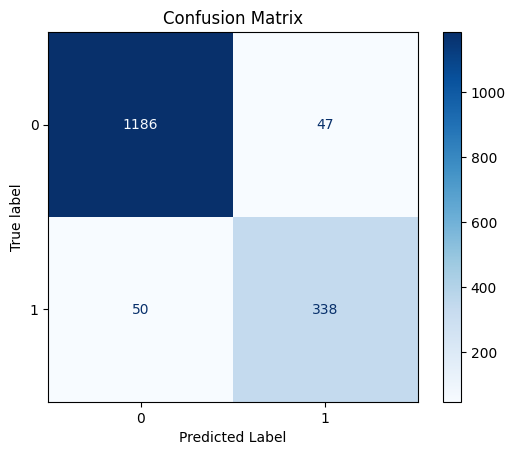

In [ ]:
cm7 = confusion_matrix(y_test, y_preds_sm7)
disp = ConfusionMatrixDisplay(confusion_matrix=cm7)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tune

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
   'n_neighbors': [2,3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search2 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid)
knn_tuned=grid_search2.fit(X_train_sm,y_train_sm)
print(grid_search2.best_estimator_)

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')


In [ ]:
y_preds_sm7_tn = knn_tuned.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm7_tn))
auc_score7_tn = roc_auc_score(y_preds_sm7_tn,y_test)
print(f"AUC-ROC Score: {auc_score7_tn:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1233
           1       0.90      0.89      0.90       388

    accuracy                           0.95      1621
   macro avg       0.93      0.93      0.93      1621
weighted avg       0.95      0.95      0.95      1621

AUC-ROC Score: 0.9317


In [ ]:
#training accuracy
y_preds_train_sm7_tn = knn_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm7_tn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5165
           1       1.00      1.00      1.00      1526

    accuracy                           1.00      6691
   macro avg       1.00      1.00      1.00      6691
weighted avg       1.00      1.00      1.00      6691



Text(0.5, 0, 'Predicted Label')

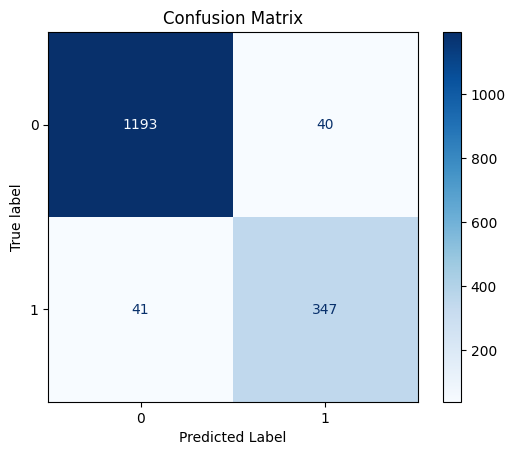

In [ ]:
cm7_tn = confusion_matrix(y_test, y_preds_sm7_tn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm7_tn)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## Naive Bias

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model8=BernoulliNB()

model8.fit(X_train_sm,y_train_sm)
y_preds_sm8 = model8.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm8))
auc_score8 = roc_auc_score(y_preds_sm8,y_test)
print(f"AUC-ROC Score: {auc_score8:.4f}")


              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1233
           1       0.52      0.79      0.63       388

    accuracy                           0.78      1621
   macro avg       0.72      0.78      0.73      1621
weighted avg       0.83      0.78      0.79      1621

AUC-ROC Score: 0.7214


In [ ]:
#training accuracy
y_preds_train_sm8 = model8.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm8))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      5165
           1       0.51      0.76      0.61      1526

    accuracy                           0.78      6691
   macro avg       0.71      0.77      0.73      6691
weighted avg       0.82      0.78      0.79      6691



Text(0.5, 0, 'Predicted Label')

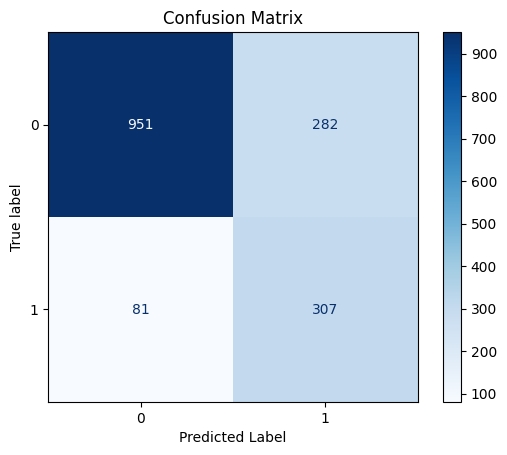

In [ ]:
cm8 = confusion_matrix(y_test, y_preds_sm8)
disp = ConfusionMatrixDisplay(confusion_matrix=cm8)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tuned


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'binarize': [0.0, 0.1, 0.5],
    'fit_prior': [True, False]
}

grid_search11 = GridSearchCV(estimator=BernoulliNB(), param_grid=param_grid)
nb_tuned=grid_search11.fit(X_train_sm,y_train_sm)
print(grid_search11.best_estimator_)

BernoulliNB(alpha=0.1)


In [ ]:
y_preds_sm7_nb = nb_tuned.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm7_nb))
auc_score7_nb = roc_auc_score(y_preds_sm7_nb,y_test)
print(f"AUC-ROC Score: {auc_score7_nb:.4f}")

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1233
           1       0.52      0.79      0.63       388

    accuracy                           0.78      1621
   macro avg       0.72      0.78      0.73      1621
weighted avg       0.83      0.78      0.79      1621

AUC-ROC Score: 0.7222


In [ ]:
#training accuracy
y_preds_train_sm7_nb = nb_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm7_nb))

              precision    recall  f1-score   support

           0       0.92      0.78      0.85      5165
           1       0.51      0.76      0.61      1526

    accuracy                           0.78      6691
   macro avg       0.71      0.77      0.73      6691
weighted avg       0.82      0.78      0.79      6691



In [ ]:
#saving pickel model,knn_tuned, rf_tuned,rf_tuned1
import pickle
pickle.dump(knn_tuned, open('knn_tuned.pkl', 'wb'))
pickle.dump(rf_tuned, open('rf_tuned.pkl', 'wb'))
pickle.dump(rf_tuned1, open('rf_tuned1.pkl', 'wb'))

In [ ]:
#save above model in same directory colab
from google.colab import files
files.download('knn_tuned.pkl')
files.download('rf_tuned.pkl')
files.download('rf_tuned1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
from google.colab import files
pickle.dump(model_pipline1, open('model_pipline1.pkl', 'wb'))
files.download('model_pipline1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Catboost

In [ ]:
X_train[noms] = X_train[noms].astype('category')
X_train[ords] = X_train[ords].astype('category')
X_test[noms]=X_test[noms].astype('category')
X_test[ords]=X_test[ords].astype('category')

In [ ]:
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=['job','marital','default','housing','loan','contact','month','education',"poutcome"], random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=2000,          # Number of boosting iterations
    learning_rate=0.1,        # Learning rate
    depth=6,                  # Depth of the trees
    loss_function='Logloss',  # Loss function for binary classification
    eval_metric='AUC',        # Evaluation metric
    verbose=100,              # Print training progress every 100 iterations
    random_seed=123           # Ensures reproducibility
)

# Train the model
model_cat.fit(X_resampled , y_resampled, eval_set=(X_test, y_test), cat_features=['job','marital','default','housing','loan','contact','month','education',"poutcome"],)



0:	test: 0.8732253	best: 0.8732253 (0)	total: 171ms	remaining: 5m 42s
100:	test: 0.9171433	best: 0.9171433 (100)	total: 8.73s	remaining: 2m 44s
200:	test: 0.9282489	best: 0.9282489 (200)	total: 17.4s	remaining: 2m 35s
300:	test: 0.9384244	best: 0.9384244 (300)	total: 25.7s	remaining: 2m 24s
400:	test: 0.9447266	best: 0.9447350 (399)	total: 35s	remaining: 2m 19s
500:	test: 0.9506693	best: 0.9506693 (500)	total: 41.8s	remaining: 2m 5s
600:	test: 0.9549481	best: 0.9549628 (598)	total: 50.5s	remaining: 1m 57s
700:	test: 0.9589865	best: 0.9590116 (699)	total: 56s	remaining: 1m 43s
800:	test: 0.9619819	best: 0.9619903 (799)	total: 1m 2s	remaining: 1m 33s
900:	test: 0.9651257	best: 0.9651320 (899)	total: 1m 8s	remaining: 1m 23s
1000:	test: 0.9673686	best: 0.9673707 (999)	total: 1m 13s	remaining: 1m 13s
1100:	test: 0.9689426	best: 0.9689426 (1100)	total: 1m 21s	remaining: 1m 6s
1200:	test: 0.9697327	best: 0.9697327 (1200)	total: 1m 24s	remaining: 56.2s
1300:	test: 0.9711227	best: 0.9711227 (12

In [ ]:
# Make predictions on the test set
y_pred_cat = model_cat.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred_cat))
auc_score_cat1 = roc_auc_score(y_pred_cat,y_test)
print(f"AUC-ROC Score: {auc_score_cat1:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1233
           1       0.88      0.91      0.89       388

    accuracy                           0.95      1621
   macro avg       0.92      0.94      0.93      1621
weighted avg       0.95      0.95      0.95      1621

AUC-ROC Score: 0.9242


In [ ]:
#training accuracy
y_preds_train_cat1 = model_cat.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_cat1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5165
           1       0.96      0.96      0.96      1526

    accuracy                           0.98      6691
   macro avg       0.97      0.97      0.97      6691
weighted avg       0.98      0.98      0.98      6691



#### hyperparameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10],
    'n_estimators': [100, 200, 300],
}

model222 = CatBoostClassifier(learning_rate=0.1, depth=6, n_estimators=100, l2_leaf_reg=1, subsample=0.8, cat_features=['job','marital','default','housing','loan','contact','month','education',"poutcome"])
grid_search222 = GridSearchCV(model222, param_grid, cv=3, scoring='accuracy')
nb_tuned1=grid_search222.fit(X_resampled , y_resampled)
print(grid_search222.best_estimator_)

Streaming output truncated to the last 5000 lines.
101:	learn: 0.3383706	total: 6.96s	remaining: 6.69s
102:	learn: 0.3372344	total: 7.01s	remaining: 6.6s
103:	learn: 0.3361119	total: 7.06s	remaining: 6.52s
104:	learn: 0.3347985	total: 7.11s	remaining: 6.43s
105:	learn: 0.3333557	total: 7.15s	remaining: 6.34s
106:	learn: 0.3321685	total: 7.22s	remaining: 6.28s
107:	learn: 0.3309767	total: 7.27s	remaining: 6.19s
108:	learn: 0.3297633	total: 7.32s	remaining: 6.11s
109:	learn: 0.3285201	total: 7.36s	remaining: 6.02s
110:	learn: 0.3267981	total: 7.41s	remaining: 5.94s
111:	learn: 0.3256905	total: 7.46s	remaining: 5.86s
112:	learn: 0.3249289	total: 7.51s	remaining: 5.78s
113:	learn: 0.3238554	total: 7.56s	remaining: 5.7s
114:	learn: 0.3227425	total: 7.6s	remaining: 5.62s
115:	learn: 0.3218012	total: 7.65s	remaining: 5.54s
116:	learn: 0.3206730	total: 7.7s	remaining: 5.46s
117:	learn: 0.3195342	total: 7.75s	remaining: 5.38s
118:	learn: 0.3191859	total: 7.76s	remaining: 5.28s
119:	learn: 0.318

In [ ]:
y_preds_cat_tn1 = grid_search222.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_cat_tn1))
auc_score_cat_tn1 = roc_auc_score(y_preds_cat_tn1,y_test)
print(f"AUC-ROC Score: {auc_score_cat_tn1:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1233
           1       0.86      0.90      0.88       388

    accuracy                           0.94      1621
   macro avg       0.91      0.93      0.92      1621
weighted avg       0.94      0.94      0.94      1621

AUC-ROC Score: 0.9127


In [ ]:
#training accuracy
y_preds_train_cat1 = grid_search222.predict(X_resampled)
print(classification_report(y_true=y_resampled,y_pred=y_preds_train_cat1))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5165
           1       0.98      0.99      0.98      5165

    accuracy                           0.98     10330
   macro avg       0.98      0.98      0.98     10330
weighted avg       0.98      0.98      0.98     10330



# Best model performance

In [ ]:
best_model=model_pipline1.named_steps['model']

In [ ]:
importances = best_model.feature_importances_

In [ ]:
feature_names = model_pipline1.named_steps['preprocessor'].get_feature_names_out()


In [ ]:
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
for nom in noms:
    nom_features = [col for col in importance_df['feature'] if col.startswith(f'noms__{nom}')]
    summed_importance = importance_df[importance_df['feature'].isin(nom_features)]['importance'].sum()
    aggregated_row = pd.DataFrame({'feature': [nom], 'importance': [summed_importance]})
    importance_df = pd.concat([importance_df[~importance_df['feature'].isin(nom_features)], aggregated_row])
importance_df = importance_df.sort_values(by='importance', ascending=False)


In [ ]:
# remove the name.replace('noms__', '').replace('ordinal__', '').replace('quants__', '') in column fetures in importnce df

feature_names1 = [name.replace('noms__', '').replace('ordinal__', '').replace('quants__', '') for name in importance_df["feature"]]
importance_df["feature"]=feature_names1

In [ ]:
import plotly.express as px
importance_df['importance_percentage'] = 100 * importance_df['importance'] / importance_df['importance'].sum()

fig = px.bar(
    importance_df,
    y='feature',
    x='importance_percentage',
    orientation='h',
    labels={'importance_percentage': 'Variable Importance (%)', 'feature': 'Variables'},
    title='Variable Importance Plot'
)

fig.update_layout(
    yaxis=dict(autorange="reversed"),
    xaxis_title='Variable Importance (%)',
    yaxis_title='Variables',
    height=600,
    width=1000
)


fig.update_traces(texttemplate='%{x:.2f}%', textposition='inside')

fig.show()

removing defualt and modelling again not increasing the accuracy

## SHAP Anlysis

In [ ]:
X_train_preprocessed=model_pipline1.named_steps['preprocessor'].transform(X_train)

In [ ]:
#X_train_preprocessed as data frame and column names is in feature_names
feature_names2 = [name.replace('noms__', '').replace('ordinal__', '').replace('quants__', '') for name in feature_names]

X_train_preprocessed1 = pd.DataFrame(X_train_preprocessed, columns=feature_names2)
X_train_preprocessed1

education  job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0           0.0         0.0              1.0               0.0            0.0   
1           2.0         0.0              0.0               0.0            0.0   
2           0.0         0.0              1.0               0.0            0.0   
3           1.0         1.0              0.0               0.0            0.0   
4           2.0         0.0              0.0               0.0            0.0   
...         ...         ...              ...               ...            ...   
6686        2.0         0.0              0.0               0.0            0.0   
6687        1.0         0.0              0.0               0.0            0.0   
6688        0.0         0.0              1.0               0.0            0.0   
6689        2.0         0.0              0.0               0.0            0.0   
6690        0.0         0.0              1.0               0.0            0.0   

      job_management  job_retired  job_self-employed  job_services  \
0                0.0          0.0                0.0           0.0   
1                1.0          0.0                0.0           0.0   
2                0.0          0.0                0.0           0.0   
3                0.0          0.0                0.0           0.0   
4                1.0          0.0                0.0           0.0   
...              ...          ...                ...           ...   
6686             1.0          0.0                0.0           0.0   
6687             0.0          0.0                0.0           1.0   
6688             0.0          0.0                0.0           0.0   
6689             1.0          0.0                0.0           0.0   
6690             0.0          0.0                0.0           0.0   

      job_student  ...  poutcome_failure  poutcome_other  poutcome_success  \
0             0.0  ...               1.0             0.0               0.0   
1             0.0  ...               0.0             0.0               1.0   
2             0.0  ...               1.0             0.0               0.0   
3             0.0  ...               0.0             1.0               0.0   
4             0.0  ...               0.0             0.0               1.0   
...           ...  ...               ...             ...               ...   
6686          0.0  ...               0.0             1.0               0.0   
6687          0.0  ...               1.0             0.0               0.0   
6688          0.0  ...               1.0             0.0               0.0   
6689          0.0  ...               1.0             0.0               0.0   
6690          0.0  ...               0.0             0.0               1.0   

      poutcome_unknown       age   balance  duration  campaign     pdays  \
0                  0.0 -1.127988 -0.376441 -0.815189 -0.039838  1.194361   
1                  0.0 -0.868268 -0.342792 -0.721954  0.594819 -1.144676   
2                  0.0  0.170610 -0.456605 -0.857568  0.594819  1.055751   
3                  0.0 -0.608548 -0.622210  0.481620  0.594819  0.709227   
4                  0.0  0.257184  0.262227  0.011209 -0.674495 -0.356334   
...                ...       ...       ...       ...       ...       ...   
6686               0.0  0.430330 -0.408441 -0.950802  2.498791 -1.170666   
6687               0.0  0.863196  1.361422  0.744372 -0.674495  0.388692   
6688               0.0 -0.348829 -0.423945 -0.793999  0.594819  0.865163   
6689               0.0 -0.521975 -0.288690 -0.861806 -0.039838  0.683238   
6690               0.0  0.690050 -0.510707  1.867425 -0.674495  1.185697   

      previous  
0    -0.326200  
1     0.822085  
2     0.535014  
3    -0.039129  
4     0.822085  
...        ...  
6686 -0.326200  
6687 -0.326200  
6688 -0.039129  
6689 -0.613271  
6690 -0.613271  

[6691 rows x 47 columns]

In [ ]:
#y_train as dataframe
y_train1 = pd.DataFrame(y_train, columns=['y'])

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_preprocessed1)

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/Final Project Stat Learning 2/3d_array.npz'

# Save the 3D array to a .npz file
np.savez(file_path, array=shap_values.values)



### Waterfall plot

In [ ]:
explainer.expected_value[1]

0.22952622926318939

In [ ]:
shap_values.values[0][:,0]

array([ 2.38187310e-03,  1.55266267e-03,  1.46549400e-02,  4.90124668e-05,
        3.02240138e-04,  2.87841024e-03,  6.00819752e-04,  2.61431878e-04,
        5.24895175e-04,  4.70944373e-04, -3.37119003e-04,  5.28521081e-04,
        4.52125958e-05,  5.89601511e-05,  4.26801637e-04, -3.07435092e-03,
        6.23874366e-05,  3.87405936e-05,  1.71934542e-02,  1.28719816e-02,
       -8.62316696e-04, -8.31949396e-04, -2.23665744e-04, -5.30836629e-04,
        2.42992957e-04,  7.38215366e-04,  3.89882706e-03,  3.60028162e-04,
        1.83558220e-03, -3.79502386e-04,  1.58698798e-03,  2.32258697e-03,
        2.02145616e-03,  2.73210765e-02,  1.66019431e-03,  2.37974501e-03,
        3.25287536e-03,  2.04374209e-02, -4.90281713e-03,  2.50548310e-02,
        1.72511005e-05, -8.52266724e-04,  4.18062482e-03,  8.05909973e-02,
        1.68823058e-03,  3.94511097e-03,  3.08273001e-03])

In [ ]:
explanation1 = shap.Explanation(
    values=shap_values.values[0][:,0],
    base_values=explainer.expected_value[0],
    data=X_train_preprocessed1.iloc[0],
    feature_names=X_train_preprocessed1.columns
)

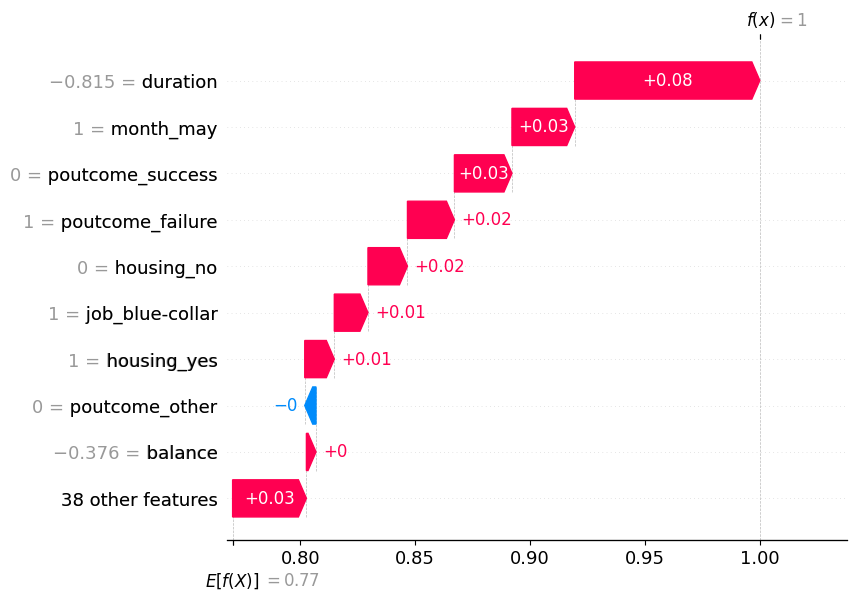

In [ ]:
shap.plots.waterfall(explanation1)


In [ ]:
explanation2 = shap.Explanation(
    values=shap_values.values[0][:,1],
    base_values=explainer.expected_value[1],
    data=X_train_preprocessed1.iloc[0],
    feature_names=X_train_preprocessed1.columns
)

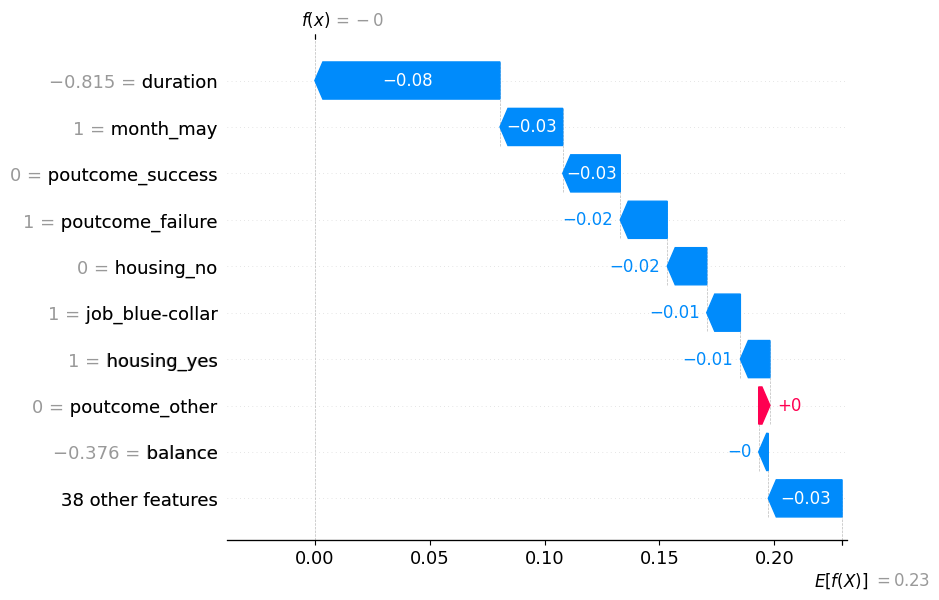

In [ ]:
shap.plots.waterfall(explanation2)

In [ ]:
shap_values.values[0:1000,:,0]

array([[ 0.00238187,  0.00155266,  0.01465494, ...,  0.00168823,
         0.00394511,  0.00308273],
       [-0.01210635, -0.00223637, -0.00252661, ..., -0.02205248,
        -0.07701834, -0.03646989],
       [ 0.00407359,  0.00127444,  0.01297332, ...,  0.00029333,
         0.01312213, -0.00288192],
       ...,
       [ 0.01177342,  0.00151167,  0.00414657, ...,  0.00059825,
        -0.04123177,  0.0097814 ],
       [-0.01063245,  0.00032579, -0.00493036, ...,  0.00541607,
         0.03027588,  0.00668867],
       [-0.00620267,  0.00109713, -0.00125912, ...,  0.00548275,
         0.02396593,  0.00271028]])

In [ ]:
shap.initjs()

### force plots

In [ ]:
from IPython.display import display, HTML

force_plot =shap.force_plot(
    base_value=explainer.expected_value[0],  # Base value for class 1
    shap_values=shap_values.values[0:1000,:,0],  # SHAP values for the first 5 instances
    features=X_train_preprocessed1.iloc[:1000],  # Feature values for the first 5 instances
    feature_names=X_train_preprocessed1.columns.tolist(),  # Feature names
    out_names="Class 0 Prediction",  # Label for the output
)
html_path = '/content/force_plot.html'

shap.save_html(html_path, force_plot)

# Display the HTML file in Colab
display(HTML(html_path))

In [ ]:
#for calss 1
force_plot1=shap.force_plot(
    base_value=explainer.expected_value[0],  # Base value for class 1
    shap_values=shap_values.values[0:1000,:,0],  # SHAP values for the first 5 instances
    features=X_train_preprocessed1.iloc[:1000],  # Feature values for the first 5 instances
    feature_names=X_train_preprocessed1.columns.tolist(),  # Feature names
    out_names="Class 1 Prediction",  # Label for the output
)
html_path1 = '/content/force_plot.html'

shap.save_html(html_path1, force_plot1)

# Display the HTML file in Colab
display(HTML(html_path1))

### beeeswam plots

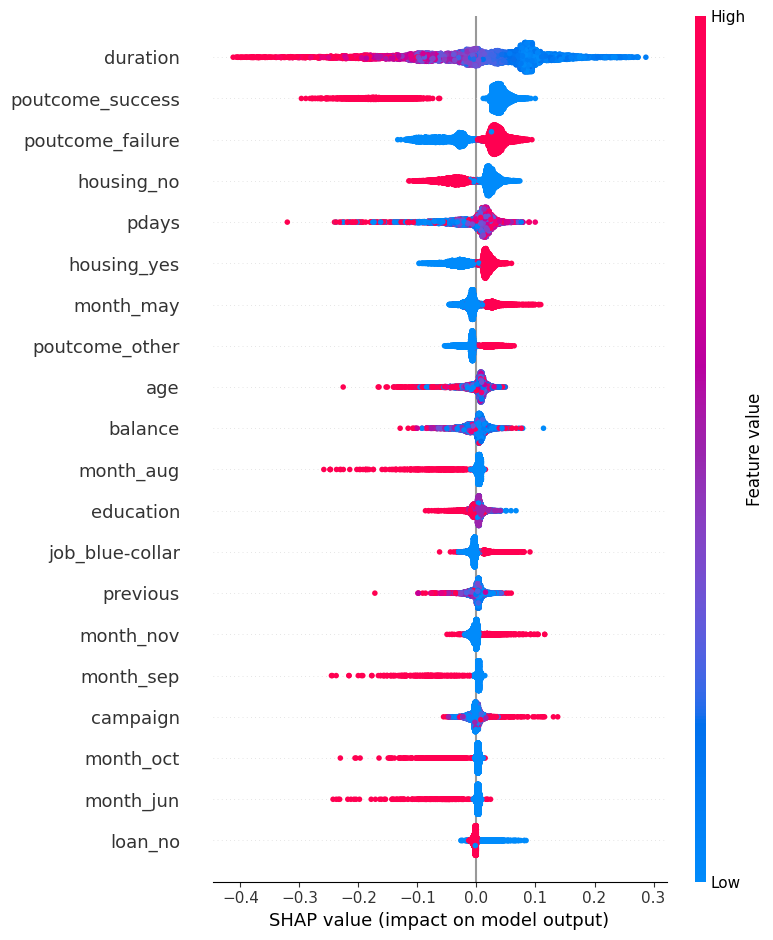

In [ ]:
shap.summary_plot(shap_values.values[:,:,0], X_train_preprocessed1)

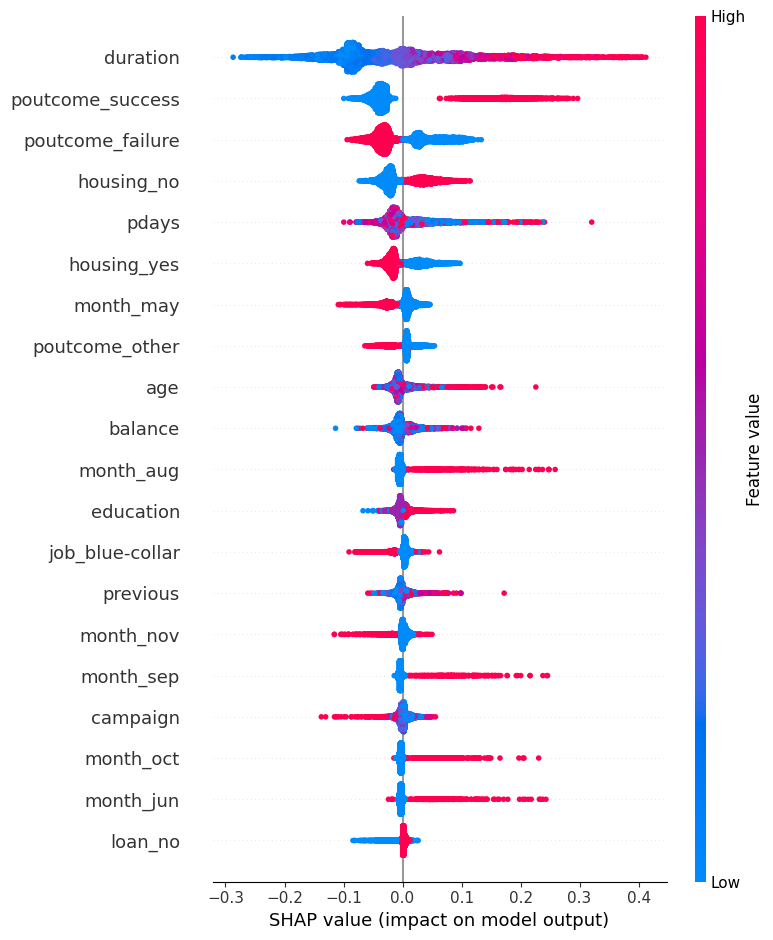

In [ ]:
shap.summary_plot(shap_values.values[:,:,1], X_train_preprocessed1)

### violin plots

In [ ]:
shap_values.values[:,:,0]

array([[ 0.00238187,  0.00155266,  0.01465494, ...,  0.00168823,
         0.00394511,  0.00308273],
       [-0.01210635, -0.00223637, -0.00252661, ..., -0.02205248,
        -0.07701834, -0.03646989],
       [ 0.00407359,  0.00127444,  0.01297332, ...,  0.00029333,
         0.01312213, -0.00288192],
       ...,
       [ 0.00361735,  0.0018446 ,  0.01374458, ...,  0.0012609 ,
         0.01636439,  0.00074636],
       [-0.0037327 ,  0.00348218, -0.00483207, ..., -0.00033827,
         0.01233515,  0.01237542],
       [ 0.0084665 ,  0.00079537,  0.02219511, ..., -0.01973114,
        -0.01724688, -0.00482891]])

In [ ]:
#for class 0
shap_df0 = pd.DataFrame({
    'Feature': np.repeat(X_train_preprocessed1.columns, len(X_train_preprocessed1)),
    'SHAP Value': np.concatenate(shap_values.values[:,:,0], axis=0),
    'Sample': np.tile(np.arange(len(X_train_preprocessed1)), len(X_train_preprocessed1.columns))
})

# Print the first few rows of the DataFrame
print(shap_df.head())

     Feature  SHAP Value  Sample
0  education    0.002382       0
1  education    0.001553       1
2  education    0.014655       2
3  education    0.000049       3
4  education    0.000302       4


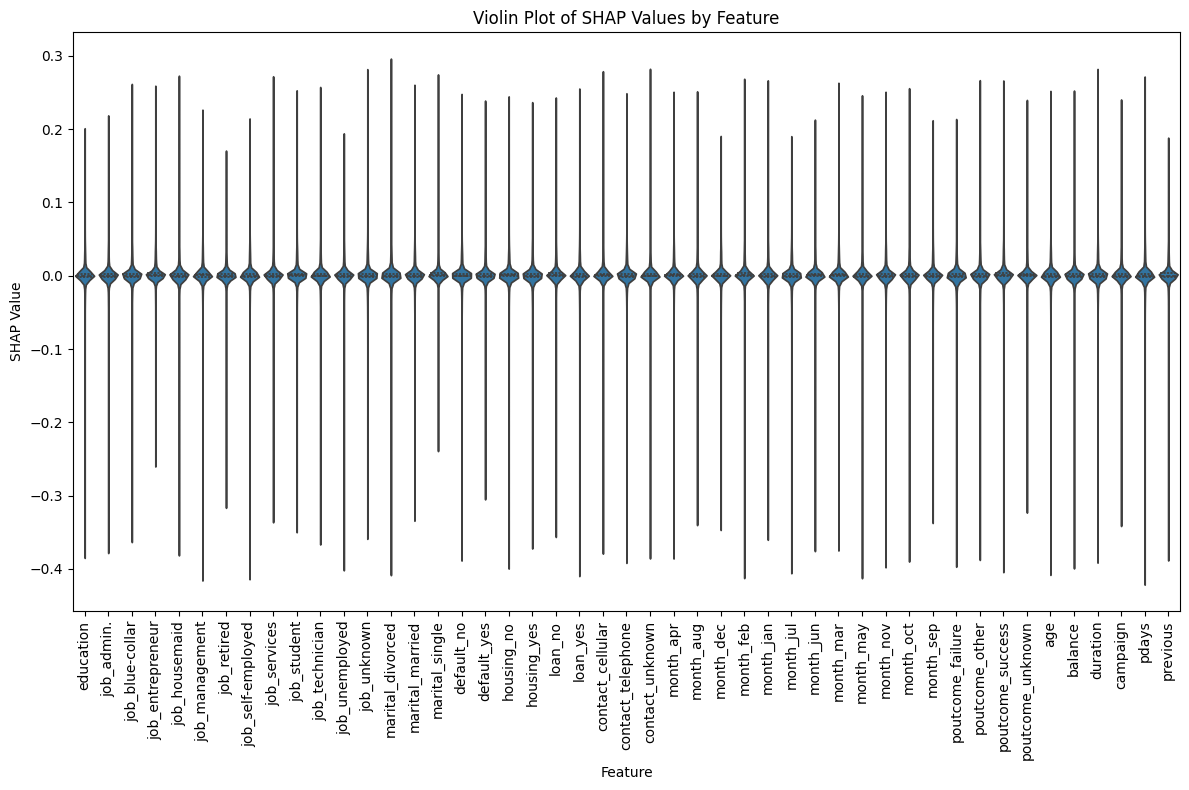

In [ ]:
plt.figure(figsize=(12, 8))

# Create the violin plot
sns.violinplot(x='Feature', y='SHAP Value', data=shap_df0, scale='width', inner='quartile')

# Customize the plot
plt.title('Violin Plot of SHAP Values by Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('SHAP Value')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#for class 0
shap_df1 = pd.DataFrame({
    'Feature': np.repeat(X_train_preprocessed1.columns, len(X_train_preprocessed1)),
    'SHAP Value': np.concatenate(shap_values.values[:,:,1], axis=0),
    'Sample': np.tile(np.arange(len(X_train_preprocessed1)), len(X_train_preprocessed1.columns))
})

# Print the first few rows of the DataFrame
print(shap_df.head())

     Feature  SHAP Value  Sample
0  education    0.002382       0
1  education    0.001553       1
2  education    0.014655       2
3  education    0.000049       3
4  education    0.000302       4


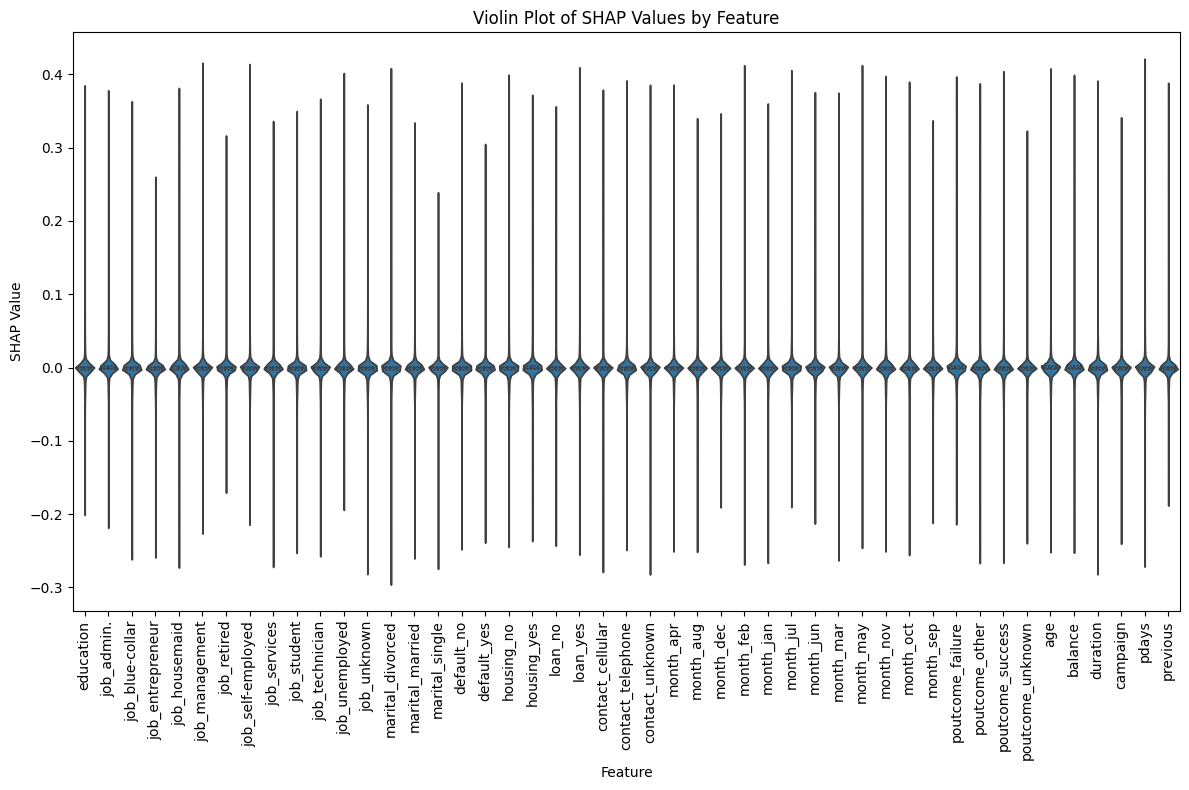

In [ ]:
plt.figure(figsize=(12, 8))

# Create the violin plot
sns.violinplot(x='Feature', y='SHAP Value', data=shap_df1, scale='width', inner='quartile')

# Customize the plot
plt.title('Violin Plot of SHAP Values by Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('SHAP Value')

# Show the plot
plt.tight_layout()
plt.show()